# A) This notebook offers a comprehensive tutorial on WE data analysis with minimal user input, using the HDF5 file format generated by Wepy.


### https://adicksonlab.github.io/wepy/_source/tutorials/data_analysis/hdf5_access/README.html

In [90]:
import os,sys
sys.path.append("Scripts/")
sys.path.append("Analysis/")
sys.path.append("Systems/")


In [91]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from cycler import cycler
import scienceplots

In [109]:
from wepy.hdf5 import WepyHDF5
from wepy.analysis.parents import resampling_panel, parent_panel, net_parent_table, ancestors
from wepy.resampling.decisions.clone_merge import MultiCloneMergeDecision

plt.style.use(['science', 'ieee'])
plt.rcParams["text.usetex"] = False  # if you don’t want LaTex
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["DejaVu Serif"]  # fallback
plt.rcParams["figure.dpi"] = 200
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 6
plt.rcParams['scatter.edgecolors'] = 'black'
plt.rcParams['lines.markeredgecolor'] = 'black'
plt.rcParams.update({'axes.prop_cycle': cycler('color', ['#bc80bd', '#fb8072', '#b3de69', '#fdb462', '#fccde5', '#8dd3c7',
                                    '#ffed6f', '#bebada', '#80b1d3', '#ccebc5', '#d9d9d9'])})

### First load & open the HDF5 file named "wepy.results.h5" with "read" mode. Also provide the time interval between cycles i.e number of MD steps * MD integration time step.

In [110]:
filename = "./Systems/chignolin/unfolding_runs/simdata_runtest_0_steps5000_cycs10000/wepy.results.h5"
wepy_h5 = WepyHDF5(filename, mode='r')
wepy_h5.open()


### To extract & display the necessary informations from the HDF5 file for convergence check & MFPT calculation, run the following cell. 

In [111]:
if "steps" in filename:
            steps_str = filename.split("steps")[1].split("_")[0]
            delta_t = int(steps_str) * 0.002  # ps
print(f"Delta t: {delta_t} ps")
# Print all the basic informations related to the WE simulations
n_walkers = wepy_h5.num_init_walkers(0)       # Number of walkers
warped_walker_idxs = [i[0] for i in list(wepy_h5.h5['/runs/0/warping/walker_idx'])]   # Warped walker ids
cycle_idxs = np.array(list(wepy_h5.h5['/runs/0/warping/_cycle_idxs']))                # Corresponding ids
w_i = wepy_h5.h5['/runs/0/warping/weight']    # weights of the walkers when they reached the target state for the first time
print(w_i)
w_i = np.array([i[0] for i in w_i])
T_list = cycle_idxs * delta_t * 0.001 * n_walkers  # Convert to ns

# Always close the HDF5 file after operations
wepy_h5.close()


print('Number of walkers:', n_walkers, '\n')
print('Cycle indices when the walkers reach the target:\n', cycle_idxs, '\n')
print('Indices of the walkers who reach the target (warped walkers):\n', warped_walker_idxs, '\n')
print('Weights of the warped walkers:\n', w_i, '\n')
print('Cumulative simulation time points (ns) when walkers reach the target:\n', T_list, '\n')
print(f'For example: Walker {warped_walker_idxs[0]} reached the target at {cycle_idxs[0]}th cycle with weight {w_i[0]}.')

Delta t: 10.0 ps
<HDF5 dataset "weight": shape (557, 1), type "<f8">
Number of walkers: 16 

Cycle indices when the walkers reach the target:
 [  25   25   29   46   53   55   64   68   73   97  104  117  117  123
  123  126  131  131  132  132  133  138  140  140  140  141  141  142
  142  147  150  152  152  152  154  154  154  185  185  193  195  197
  198  198  198  204  205  206  207  215  216  216  218  221  223  224
  228  230  230  235  236  236  236  238  239  240  242  244  245  246
  248  249  249  252  255  257  260  262  263  265  267  268  268  269
  271  275  276  277  279  279  281  282  282  283  283  284  285  285
  291  292  298  300  306  306  308  311  311  311  314  314  316  319
  319  320  320  320  321  322  329  331  332  333  333  335  336  338
  341  350  352  354  354  358  361  363  363  364  366  368  369  369
  370  373  374  376  377  377  378  379  382  383  388  390  392  398
  398  402  404  404  407  409  410  421  423  424  434  443  444  444
  453

In [112]:
len(cycle_idxs)

557

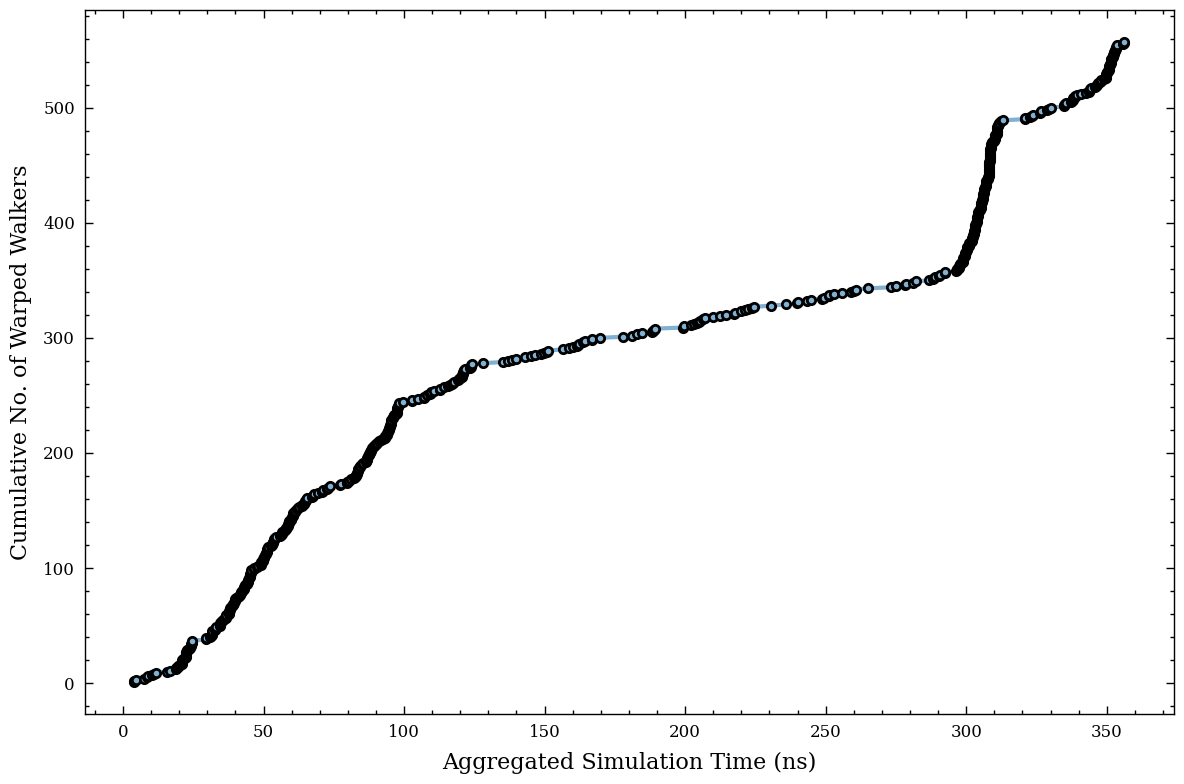

In [117]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming T_list and warped_walker_idxs are already defined as in your code
# Sort the timepoints
sorted_times = np.sort(T_list)
cumulative_counts = np.arange(1, len(sorted_times) + 1)  # 1-based count

# Plot
plt.plot(sorted_times, cumulative_counts, marker='o', linestyle='-', color='#80b1d3',markersize=3, linewidth=1.5)
#print(sorted_times[36], cumulative_counts[36])
plt.xlabel('Aggregated Simulation Time (ns)')
plt.ylabel('Cumulative No. of Warped Walkers')
plt.tight_layout()
plt.show()


Text(0, 0.5, 'Weight of warped walkers')

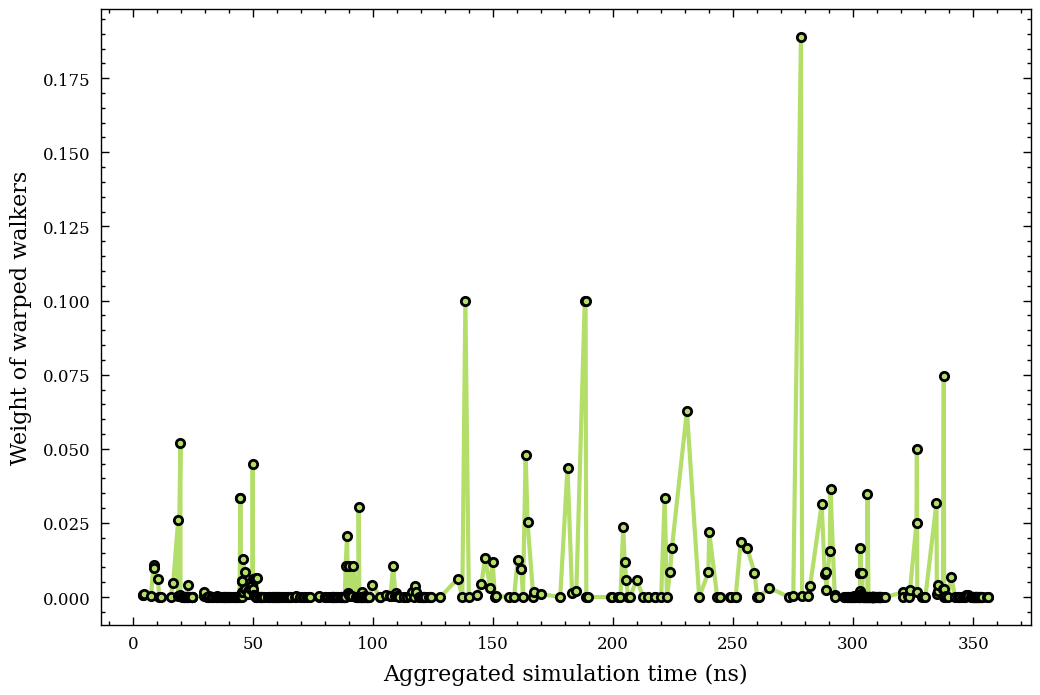

In [118]:
plt.plot(T_list, w_i, 'o', color='#b3de69', markersize=3, linestyle='-', linewidth=1.5)
plt.xlabel("Aggregated simulation time (ns)")
plt.ylabel("Weight of warped walkers")

### To check convergence, run the following cell. All the necessary informations and the aggregated cumulative probability plot will be printed.

In [115]:
help(np.cumsum)

Help on function cumsum in module numpy:

cumsum(a, axis=None, dtype=None, out=None)
    Return the cumulative sum of the elements along a given axis.
    
    Parameters
    ----------
    a : array_like
        Input array.
    axis : int, optional
        Axis along which the cumulative sum is computed. The default
        (None) is to compute the cumsum over the flattened array.
    dtype : dtype, optional
        Type of the returned array and of the accumulator in which the
        elements are summed.  If `dtype` is not specified, it defaults
        to the dtype of `a`, unless `a` has an integer dtype with a
        precision less than that of the default platform integer.  In
        that case, the default platform integer is used.
    out : ndarray, optional
        Alternative output array in which to place the result. It must
        have the same shape and buffer length as the expected output
        but the type will be cast if necessary. See :ref:`ufuncs-output-type` for

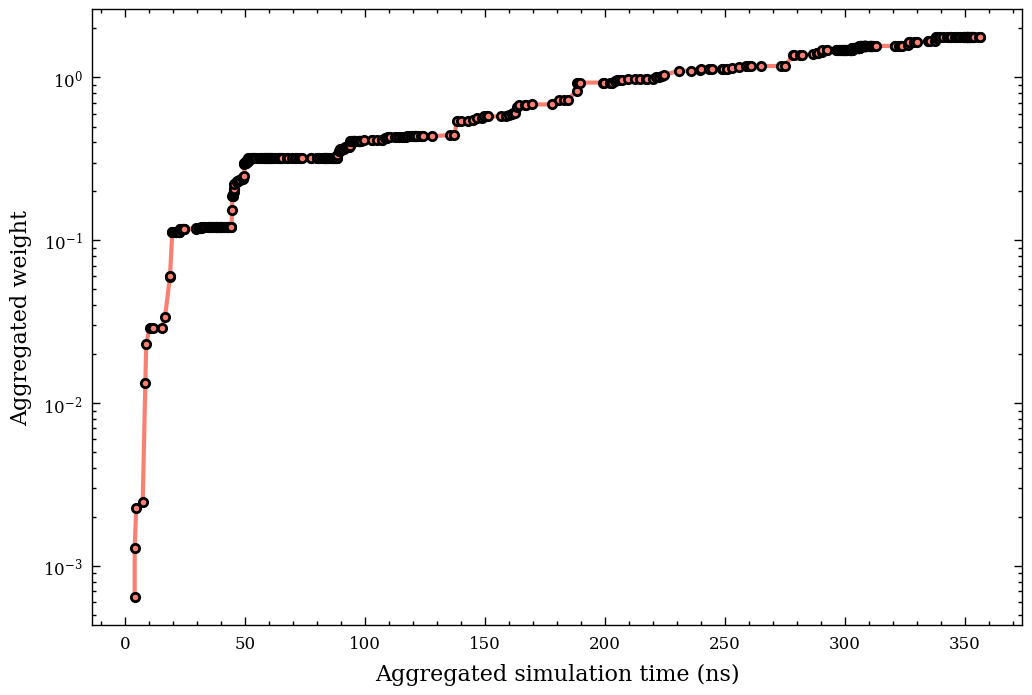

In [119]:
# Plot the data
plt.plot(T_list, np.cumsum(w_i), lw=1.5, marker = 'o',markersize=3, color = '#fb8072')#/len(w_i)
plt.xlabel("Aggregated simulation time (ns)")
plt.ylabel("Aggregated weight")
plt.yscale("log")

### Is the data converged ? If "yes", calculate MFPT by running the following cell.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


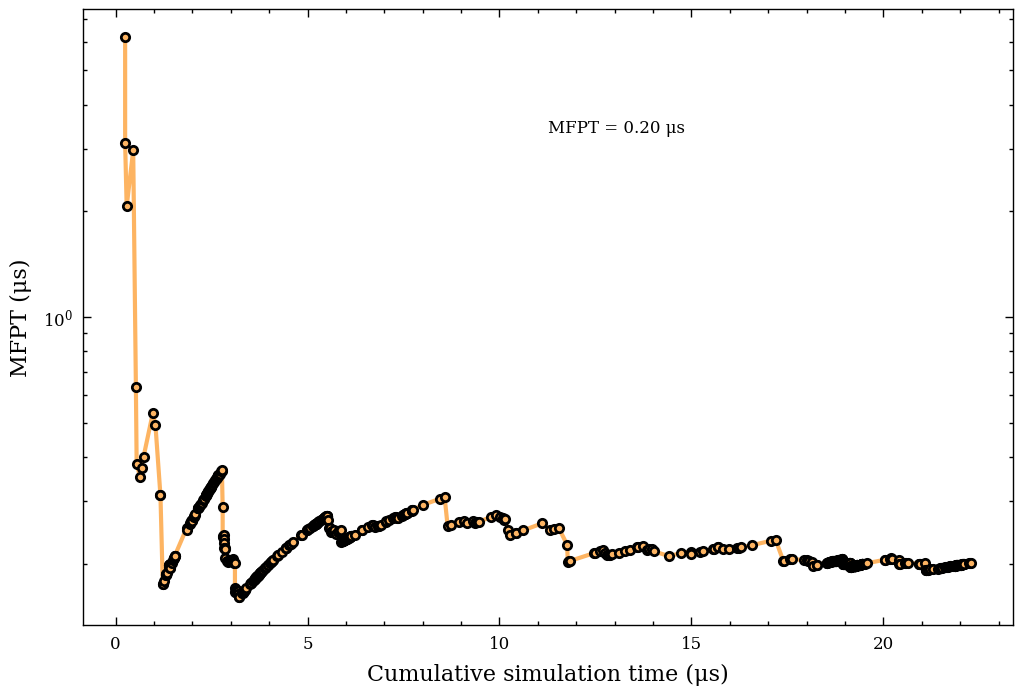

In [122]:
# MFPT calculation according to the eq.2 of the manuscript
mfpt = (T_list/(np.cumsum(w_i)))*0.001     # in micro sec
# Plot
plt.plot(T_list/n_walkers, mfpt, lw=1.5, marker = 'o', color = '#fdb462',markersize=3)
plt.xlabel("Cumulative simulation time (μs)")
plt.ylabel("MFPT (μs)")
mfpt_ = mfpt[-1]
plt.text(0.5, 0.8, f'MFPT = {mfpt_:.2f} μs', transform=plt.gca().transAxes)
plt.legend(loc='upper right', fontsize=10, frameon=False)
plt.yscale("log")


### Calculate rate by running the following cell

Processing: ./Systems/chignolin/unfolding_runs/simdata_runtest_0_steps5000_cycs10000/wepy.results.h5


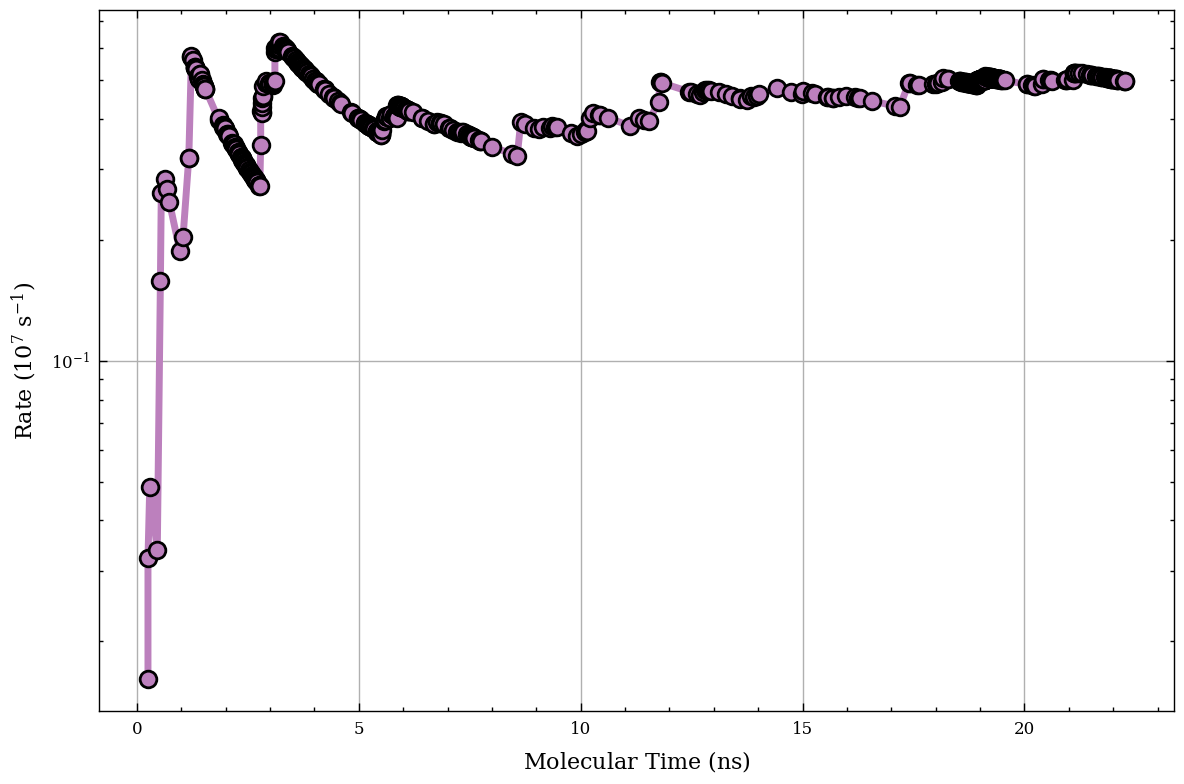

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import os
from wepy.hdf5 import WepyHDF5


print(f"Processing: {filename}")

# Open file
wepy_h5 = WepyHDF5(filename, mode='r')
wepy_h5.open()

# ---- Infer timestep from folder name (optional) ----
folder_name = os.path.basename(os.path.dirname(filename))

if "steps" in folder_name:
    steps_str = folder_name.split("steps")[1].split("_")[0]
    delta_t = int(steps_str) * 0.002  # ps
else:
    delta_t = 5000 * 0.002  # fallback (ps)

# ---- Extract warping data ----
n_walkers = wepy_h5.num_init_walkers(0)

cycle_idxs = np.array(wepy_h5.h5['/runs/0/warping/_cycle_idxs'])
weights = np.array([x[0] for x in wepy_h5.h5['/runs/0/warping/weight']])

wepy_h5.close()

# ---- Compute molecular time (ns) ----
T_list = cycle_idxs * delta_t * 1e-3  # ps → ns

# ---- MFPT calculation ----
mfpt = (T_list * n_walkers / np.cumsum(weights)) * 1e-9
rate = 1.0 / mfpt
rate_1e8 = rate / 1e7

fig, ax = plt.subplots()
ax.plot(T_list, rate_1e8, lw=2.5, marker='o', label="CoWERA")


ax.set_xlabel(r'$\mathrm{Molecular\ Time\ (ns)}$')
ax.set_ylabel(r'$\mathrm{Rate\ (10^7\ s^{-1})}$')

ax.set_yscale("log")
ax.grid(True)


plt.tight_layout()
plt.show()

### get run statistics...

In [129]:
import numpy as np
from wepy.hdf5 import WepyHDF5
import os


# --------------------------------

print(f"Processing file:\n{filename}\n")

wepy_h5 = WepyHDF5(filename, mode='r')
wepy_h5.open()

# Infer delta_t from folder name
folder_name = os.path.basename(os.path.dirname(filename))

if "steps" in folder_name:
    steps_str = folder_name.split("steps")[1].split("_")[0]
    delta_t = int(steps_str) * 0.002  # ps per cycle
else:
    delta_t = 5000 * 0.002  # fallback (ps per cycle)

# Extract warping cycle indices
cycle_idxs = np.array(wepy_h5.h5['/runs/0/warping/_cycle_idxs'])
n_walkers = wepy_h5.num_init_walkers(0)

wepy_h5.close()

# ---- Basic Statistics ----
total_warp_events = len(cycle_idxs)
max_cycle_idx = np.max(cycle_idxs)

max_time_ns = max_cycle_idx * delta_t * 0.001  # ps → ns

print("Run Summary")
print("-----------")
print(f"Total warping events : {total_warp_events}")
print(f"Max cycle index      : {max_cycle_idx}")
print(f"Molecular time (ns)  : {max_time_ns:.3f}")
print(f"Initial walkers      : {n_walkers}")

Processing file:
./Systems/chignolin/unfolding_runs/simdata_runtest_0_steps5000_cycs10000/wepy.results.h5

Run Summary
-----------
Total warping events : 557
Max cycle index      : 2227
Molecular time (ns)  : 22.270
Initial walkers      : 16
